



# BIBLIOTECAS

In [3]:
import os
import urllib.request
import pandas as pd
import numpy as np
import plotly.express as px
from pickle import PickleBuffer
from matplotlib import pyplot as pt
from scipy.integrate import odeint
from scipy.optimize import fsolve, root, minimize, least_squares
from scipy.optimize import curve_fit

## Dados

link para dados populacionais: http://tabnet.datasus.gov.br/cgi/deftohtm.exe?ibge/cnv/popsvs2024br.def

Age_distribution_2020_130260_Manaus-ibge.csv \\
Age_distribution_2020_330455_RIODEJANEIRO_ibge.csv \\
Age_distribution_2020_355030_SAOPAULO_ibge.csv \\
Age_distribution_2020_UF_SP_ibge.csv \\
Age_distribution_2020_UF_RJ_ibge.csv \\
Age_distribution_2020_UF_AM_ibge.csv

In [56]:
# Link direto para o arquivo CSV no GitHub (raw)
# Arquivo sem tratamento, baixado direto do DataSus - Estrutura Etária da Cidade
url1 = 'https://raw.githubusercontent.com/emanoelpereira/modelo-endemia/refs/heads/main/DATA/Age_distribution_2020_355030_SAOPAULO_ibge.csv'

# Arquivo sem tratamento, baixado direto do DataSus - Estrutura Etária do Estado UF
url2 = 'https://raw.githubusercontent.com/emanoelpereira/modelo-endemia/refs/heads/main/DATA/Age_distribution_2020_UF_SP_ibge.csv'

# Carregar o arquivo ignorando metadados iniciais
# Remover a última linha, que contém a soma total
# Remover colunas "Região" e "Total"
# Remover linhas totalmente vazias
# convertendo o DataFrame para uma lista
df = pd.read_csv(url1, delimiter=";", skiprows=4, encoding="ISO-8859-1")
df = df[df.iloc[:, 0] != "Total"]
df = df.drop(columns=["Região", "Total"])
df = df.dropna(how="all")
age_structure = df.values.flatten()  # Retorna um array 1D (vetor)

df = pd.read_csv(url2, delimiter=";", skiprows=4, encoding="ISO-8859-1")
df = df[df.iloc[:, 0] != "Total"]
df = df.drop(columns=["Região", "Total"])
df = df.dropna(how="all")
age_structure_UF = df.values.flatten()  # Retorna um array 1D (vetor)

print(age_structure)

[ 742408.  770974.  759315.  827194.  908644.  932557.  967662. 1006959.
  938790.  823196.  754738.  682621.  585038.  458943.  337375.  226558.
  289556.]


In [54]:
# Novo agrupamento da distribuição etária
# Fonte: Data SUS http://tabnet.datasus.gov.br/cgi/deftohtm.exe?ibge/cnv/popsvs2024br.def

###############################################################################################
################################# Utilizado antes##############################################
    #Fonte da População IBGE2023
    # Estado de SP / cidade São Paulo
#    PopUF        = np.array([10832832, 13556924, 12370914, 7650568])            # População Estado
#    PopCit       = np.array([2674093, 3559246, 3195600, 2023060])               # População Cidade
#    Prop_PopUF   = PopUF/PopUF.sum()                                            # Distribuição populacional UF
#    Prop_PopCit  = PopCit/PopCit.sum()                                          # Distribuição populacional Cidade
# valor calculado Prop_PopUF =  [0.24392096 0.30525886 0.27855368 0.17226649]
# valor calculado Prop_PopCit = [0.23350447 0.31079692 0.27904299 0.17665562]
################################################################################################

def reagrupar_faixaetaria(vetor, n_classes):
    if n_classes < 1:
        raise ValueError("O número de classes deve ser pelo menos 1.")

    tamanho_vetor = len(vetor)
    classes_agrupadas = tamanho_vetor // (n_classes)
#    print(classes_agrupadas)
    novo_vetor = []
    inicio = 0

    for i in range(n_classes-1):
        novo_vetor.append(sum(vetor[inicio:inicio + classes_agrupadas]))
        inicio += classes_agrupadas

    novo_vetor.append(sum(vetor[inicio:]))  # Última classe com os valores restantes
    return np.array(novo_vetor)

n_classes = 4

PopCit = reagrupar_faixaetaria(age_structure, n_classes)
PopUF =  reagrupar_faixaetaria(age_structure_UF, n_classes)

Prop_PopUF   = PopUF/PopUF.sum()   # Proporção da Distribuição populacional UF
Prop_PopCit  = PopCit/PopCit.sum() # Proporção da Distribuição populacional Cidade

print(PopCit)
print(PopUF)
print(Prop_PopUF)
print(Prop_PopCit)

[3099891. 3815822. 3199345. 1897470.]
[12197363. 14215964. 12104160.  7005704.]
[0.26793735 0.3122796  0.26588997 0.15389308]
[0.25805484 0.31765354 0.26633403 0.15795759]


In [51]:
    #Fonte
    vac_UF = np.array([5121581, 13763379, 12133025, 7310940])                   # Vacinados Estado
    prop_vac = np.amin(np.c_[vac_UF/PopUF, np.ones_like(vac_UF)], axis=1)       # Proporção VACINADOS ESTADO
    prop_nvac = 1 - prop_vac                                                    # Proporção não VACINADOS ESTADO
    Nwsp_i = (prop_vac) * PopCit                                                # Estimativa VACINADOS Cidade
    Nusp_i = (1 - prop_vac) * PopCit                                            # Estimativa não VACINADOS Cidade

    propinf = 0.8                                                               # Proporção estimada de população já infectada
    PopCitn = (1-propinf) * PopCit * (1-prop_vac)
    PopCitu = propinf * PopCit * (1-prop_vac)
    PopCitv = (1-propinf) * PopCit * (prop_vac)
    PopCitw = propinf * PopCit * (prop_vac)

    infect0 = 1

y0 = np.r_[PopCitn, PopCitu, PopCitv, PopCitw,                 # S (Sn,Su,Sv,Sw)
     np.zeros(16),                                             # E
     np.zeros(16),                                             # A
     np.zeros(16),                                             # I
     np.zeros(16),                                             # H
     np.zeros(16)]                                             # R

y0[0:4] -= 1
y0[16:20] = 1 # introduzimos indivíduos infectados nas faixas etárias dos vacinados de En

##Parâmetros:


###Matriz de Contato e Beta

In [58]:
def aggregate_age_matrix(mat_cont, aggregate_indices, age_structure=None, silent=True):
    if age_structure is None:
        age_structure = np.ones(mat_cont.shape[0])

    age_structure = np.array(age_structure, dtype=float)
    #compara número de linhas com colunas
    if mat_cont.shape[0] != mat_cont.shape[1]:
        raise ValueError("mat_cont is not a square matrix")
    #compara número de faixas etárias
    if len(age_structure) < mat_cont.shape[0]:
        raise ValueError("age_structure is smaller than the linear dimension of mat_cont")

    if len(age_structure) > mat_cont.shape[0]:
        if silent == False:
            print("age_structure is bigger than linear size of mat_cont, aggregating the last values in one")
        #agrupa os últimos pesos
        age_structure[mat_cont.shape[0]-1] = sum(age_structure[mat_cont.shape[0]-1:])
    # matriz quadrada com o número de agrupamentos novos
    new_mat_cont = np.zeros((len(aggregate_indices), len(aggregate_indices)))

    for a, indices_i in enumerate(aggregate_indices):
        for b, indices_j in enumerate(aggregate_indices):
            Na = 0
            for i in indices_i:
                for j in indices_j:
                    new_mat_cont[a, b] += age_structure[i] * mat_cont[i, j]
                Na += age_structure[i]
            new_mat_cont[a, b] /= Na

    return new_mat_cont

In [57]:
# Matriz de Contato do Brasil
url3 = 'https://raw.githubusercontent.com/emanoelpereira/modelo-endemia/refs/heads/main/DATA/BRA_data.csv'
mat_cont = pd.read_csv(url3)

# Transformar em matriz (NumPy array)
mat_cont = mat_cont.to_numpy()

# Matriz de Contato
mat_cont = pd.read_csv(url3)

# Transformar em matriz (NumPy array)
mat_cont = mat_cont.to_numpy()

# Define os índices para agregação
aggregate_indices = [range(4), range(4, 8), range(8, 12), range(12, 16)]

Matrix_Contact = aggregate_age_matrix(mat_cont, aggregate_indices, age_structure)

# Exibir o resultado
print(age_structure)
print (matcontact)

##################################################################################
###################Valor anterior
# Matrix_Contact = np.array([[12.16225114,  3.5903678,   2.56136575,  0.57682922],
#                            [ 3.26339927,  8.10131607,  4.24930738,  0.6747869 ],
#                            [ 3.14804123,  4.9774246,   5.06808749,  0.79723409],
#                            [ 2.36576344,  2.19144427,  2.07597498,  1.1998408 ]])
################################################################################

################################################################################
#Beta
r=10
B0=r*.01156292
################################################################################

Contact=np.r_[Matrix_Contact]
Contact_2 = np.r_[Contact,Contact,Contact,Contact]
MContact = np.r_['-1',Contact_2,Contact_2,Contact_2,Contact_2]

[ 742408.  770974.  759315.  827194.  908644.  932557.  967662. 1006959.
  938790.  823196.  754738.  682621.  585038.  458943.  337375.  226558.
  289556.]
[[10.10000523  3.78900106  2.70796952  0.95013553]
 [ 3.37393827  6.98996762  3.63232702  1.10205869]
 [ 2.7604727   4.88005716  4.66212996  1.28903444]
 [ 1.80376629  2.84821539  2.75918256  1.73991773]]


### Proporções:  $\mu_i, \sigma_i,\alpha_i$
* hospitalizados que morrem: $\mu_i$
* infectados que são hospitalizados: $\sigma_i$
* infectados assintomáticos: $\alpha_i$

In [ ]:
#Capítulo 4 Tese Leo
################################################################################
# Proporção dos hospitalizados que morrem
mu_0, mu_1, mu_2, mu_3 = 0.091, 0.144, 0.243, 0.473

# Proporção dos infectados que são hospitalizados
sigma_0, sigma_1, sigma_2, sigma_3 = 0.001, 0.008, 0.021, 0.101

# Proporção dos infectados assintomáticos
alpha_0, alpha_1, alpha_2, alpha_3 = 0.695, 0.440, 0.440, 0.310

# Sigma, Alpha dependem da faixa etária
Sigma = np.array([sigma_0, sigma_1, sigma_2, sigma_3])
Alpha = np.r_[alpha_0, alpha_1, alpha_2, alpha_3]

### Taxas: $\nu_i$,$\gamma$ e $\omega$
* recuperação (depende da faixa etária): $\nu_i$
* desenvovimento dos sintomas: $\gamma$
* perda de imunidade: $\omega$

In [ ]:
#Capítulo 4 Tese Leo
################################################################################
# Taxa de recuperação (depende da faixa etária)
# gamma: taxa do desenvovimento dos sintomas,
# omega: taxa de perda de imunidade
nu_0, nu_1, nu_2, nu_3 = 1/9.59, 1/9.217,1/10.941, 1/12.534
Nu                     = np.array([nu_0, nu_1, nu_2, nu_3])
gamma, omega           = 1/5.8, 1/60
################################################################################

### Infectividade relativa e redução devido a sintomas e hospitalização: $\rho, \tau, \eta$
* Infectividade relativa: $\rho$
* Redução da exposição devido a sintomas: $\tau$
* Redução da exposição devido a hospitalização: $\eta$

In [ ]:
#Capítulo 4 Tese Leo
################################################################################
# ro: infectividade relativa de individuos pré-sintomáticos,
# tau: redução da exposição devido a sintomas,
# eta: redução de exposição devido a hospitalização,
ro, tau, eta = 0.5, 0.5, 0.5
################################################################################

###Eficácia e Proteção:

*   $E_{\beta}, E_{\sigma}, E_{IH}$
*   $\varepsilon_{\beta}, \varepsilon_{\sigma}, \varepsilon_{\alpha}$



In [ ]:
################################################################################
# Eficácia dependem da classe imunológica
# Valores provisórios
E_Bn,  E_Bu,  E_Bv,  E_Bw  = 0, 0.599, 0.599, 0.599  # Efficacy (observed) against infectious contact 0, 0.499, 0.599, 0.699
E_IHn, E_IHu, E_IHv, E_IHw = 0, 0.659, 0.659, 0.659  # Efficacy against clinical symptoms 0, 0.549, 0.659, 0.859
E_Sn,  E_Su,  E_Sv,  E_Sw  = 0, 0.759, 0.759, 0.759  # Efficacy against hospitaization of infected individual 0, 0.599, 0.699, 0.89

E_B  = np.array([E_Bn,E_Bu,E_Bv,E_Bw])
E_S  = np.r_[E_Sn,E_Su,E_Sv,E_Sw]
E_IH = np.r_[E_IHn,E_IHu,E_IHv,E_IHw]
################################################################################

Epsilon_Bj = np.array([1-E_Bn,1-E_Bu,1-E_Bv,1-E_Bw])          #Epsilon_Bn,Epsilon_Bu,Epsilon_Bv,Epsilon_Bw
Epsilon_Sj = np.array([(1-E_Sn)/(1-E_Bn), (1-E_Su)/(1-E_Bu),  #Epsilon_sigma
                     (1-E_Sv)/(1-E_Bv),(1-E_Sw)/(1-E_Bw)])    #Epsilon_Sn,Epsilon_Su,Epsilon_Sv,Epsilon_Sw

Epsilon_A = np.array(np.zeros(16))                                #Epsilon_alpha
Epsilon_B = np.array(np.zeros(16))                                #Epsilon_beta
Epsilon_S = np.array(np.zeros(16))                                #Epsilon_sigma

for i in range(4):
  Epsilon_A[i]    +=  (((1-E_IH[0])*(Sigma[i]+(1-Sigma[i])*(1-Alpha[i]))-
  (1-E_S[0])*Sigma[i])/(Epsilon_Bj[0]*(1-Epsilon_Sj[0]*Sigma[i])*(1-Alpha[i]) ))
  Epsilon_A[4+i]  +=  (((1-E_IH[1])*(Sigma[i]+(1-Sigma[i])*(1-Alpha[i]))-
  (1-E_S[1])*Sigma[i])/(Epsilon_Bj[1]*(1-Epsilon_Sj[1]*Sigma[i])*(1-Alpha[i]) ))
  Epsilon_A[8+i]  +=  (((1-E_IH[2])*(Sigma[i]+(1-Sigma[i])*(1-Alpha[i]))-
  (1-E_S[2])*Sigma[i])/(Epsilon_Bj[2]*(1-Epsilon_Sj[2]*Sigma[i])*(1-Alpha[i]) ))
  Epsilon_A[12+i] +=  (((1-E_IH[3])*(Sigma[i]+(1-Sigma[i])*(1-Alpha[i]))-
  (1-E_S[3])*Sigma[i])/(Epsilon_Bj[3]*(1-Epsilon_Sj[3]*Sigma[i])*(1-Alpha[i]) ))
  Epsilon_B[i]    += Epsilon_Bj[0]
  Epsilon_B[4+i]  += Epsilon_Bj[1]
  Epsilon_B[8+i]  += Epsilon_Bj[2]
  Epsilon_B[12+i] += Epsilon_Bj[3]
  Epsilon_S[i]    += Epsilon_Sj[0]
  Epsilon_S[4+i]  += Epsilon_Sj[1]
  Epsilon_S[8+i]  += Epsilon_Sj[2]
  Epsilon_S[12+i] += Epsilon_Sj[3]

  print(Epsilon_B)

[1.    0.    0.    0.    0.401 0.    0.    0.    0.401 0.    0.    0.
 0.401 0.    0.    0.   ]
[1.    1.    0.    0.    0.401 0.401 0.    0.    0.401 0.401 0.    0.
 0.401 0.401 0.    0.   ]
[1.    1.    1.    0.    0.401 0.401 0.401 0.    0.401 0.401 0.401 0.
 0.401 0.401 0.401 0.   ]
[1.    1.    1.    1.    0.401 0.401 0.401 0.401 0.401 0.401 0.401 0.401
 0.401 0.401 0.401 0.401]


### Efeito da eficácia da vacina: $\sigma_{\epsilon}, \alpha_{\epsilon}, \beta_{\epsilon}, \delta_A, \delta_I, \delta_H$

In [ ]:
# Efeito da eficácia da vacina
sigma_Epsilon, alpha_Epsilon = np.zeros_like(Epsilon_S), np.zeros_like(Epsilon_A)
beta_Epsilon = B0*Epsilon_B

for i in range(4):
  sigma_Epsilon[i::4] = Epsilon_S[i::4]*Sigma[i]
  alpha_Epsilon[i::4] = Epsilon_A[i::4]*Alpha[i]

DeltaA = (1-sigma_Epsilon) * alpha_Epsilon
DeltaI = (1-sigma_Epsilon) * (1-alpha_Epsilon)
DeltaH = sigma_Epsilon

print(DeltaA)

[0.694305   0.43648    0.43076    0.27869    0.59098722 0.37273878
 0.37042185 0.24830666 0.59098722 0.37273878 0.37042185 0.24830666
 0.59098722 0.37273878 0.37042185 0.24830666]


#SISTEMA DE EDOS COM EFICÁCIAS

In [ ]:
t = np.arange(0, 365*1, 1)

def SEAIHR_endemia(y, t, MContact, B0, Epsilon_A, Epsilon_B, Epsilon_S, ro, tau,
                   eta, gamma, Sigma, Alpha, Nu, omega):

    Ni =  np.zeros(4) # Criando um vetor para armazenar as somas das faixas etárias
    # Somando as entradas correspondentes de cada faixa etária
    for i in range(4):
      Ni[i] = np.sum(y[i::4])  # Vetor faixas etárias
    N = np.tile(Ni, 4)         # concatena Ni 4 vezes
    n = 4                      # n de faixas etárias

    S, E, A, I, H, R = np.split(y,6)
    BETA = ((B0*Epsilon_B).reshape(16,1))*MContact
    dS   = - S * np.dot(BETA, (ro*E+A+(1-tau)*I+(1-eta)*H)/N)               #dS/dt
    dE   =   S * np.dot(BETA, (ro*E+A+(1-tau)*I+(1-eta)*H)/N) - gamma * E         #dE/dt
    dA, dI, dH, dR = np.zeros_like(A), np.zeros_like(I), np.zeros_like(H), np.zeros_like(R)
    sigma_Epsilon, alpha_Epsilon = np.zeros_like(H), np.zeros_like(A)
    for i in range(n):
      sigma_Epsilon[i::n] = Epsilon_S[i::n] * Sigma[i]
      alpha_Epsilon[i::n] = Epsilon_A[i::n] * Alpha[i]
      dA[i::n]            =  - Nu[i] * A[i::n]                   #dA/dt
      dI[i::n]            =  - Nu[i] * I[i::n]                   #dI/dt
      dH[i::n]            =  - Nu[i] * H[i::n]                   #dH/dt
      dR[i::n] = Nu[i] * (A[i::n] + I[i::n] + H[i::n]) - omega * R[i::n] #dR/dt

    dA +=  (1-sigma_Epsilon) * alpha_Epsilon     * gamma * E
    dI +=  (1-sigma_Epsilon) * (1-alpha_Epsilon) * gamma * E
    dH +=   sigma_Epsilon                        * gamma * E

    dS[n:2*n]   +=  omega   * (R[n:2*n]   + R[0:n])
    dS[3*n:4*n] +=  omega   * (R[2*n:3*n] + R[3*n:4*n])
    return np.r_[dS, dE, dA, dI, dH, dR]

y = odeint(SEAIHR_endemia, y0, t, args=(MContact, B0, Epsilon_A, Epsilon_B,
                                        Epsilon_S, ro, tau, eta, gamma, Sigma,
                                        Alpha, Nu, omega))

# AJUSTE DO MODELO

## Sistemas de equações algébricas:

\begin{eqnarray*}
\theta_{2,u}^l&=&\frac{\rho}{\gamma} +\frac{ \delta_{u,A}^l + (1-\tau) \cdot \delta_{u,I}^l  + (1-\eta)  \cdot \delta_{u,H}^l}{\nu^l} \\
\theta_{2,w}^l&=&\frac{\rho}{\gamma} +  \frac{ \delta_{w,A}^l + (1-\tau)\cdot  \delta_{w,I}^l  +  ( 1-\eta ) \cdot \delta_{w,H}^l  }{\nu^l} \\
{\lambda^i}^*&=&  \beta \sum\limits_{l=1}^{4}  \frac{\mathbb{C}_{i,l}}{N^l} \cdot {\lambda^l}^* \cdot \Bigg(  \varepsilon_{\beta,u} \cdot \theta_{2,u}^l \cdot {S_u^l}^* +  \varepsilon_{\beta,w} \cdot \theta_{2,w}^l\cdot {S_w^l}^*\Bigg)\\
\end{eqnarray*}


($\lambda^i$)

\begin{eqnarray*}
\theta_{2,u}^l&=&\frac{\rho}{\gamma} +\frac{ \delta_{u,A}^l + (1-\tau) \cdot \delta_{u,I}^l  + (1-\eta)  \cdot \delta_{u,H}^l}{\nu^l} \\
\theta_{2,w}^l&=&\frac{\rho}{\gamma} +  \frac{ \delta_{w,A}^l + (1-\tau)\cdot  \delta_{w,I}^l  +  ( 1-\eta ) \cdot \delta_{w,H}^l  }{\nu^l} \\
\end{eqnarray*}

\begin{equation}
{\lambda^i}^* = \frac{{\lambda^i_j}^*}{\epsilon_\beta} = \beta \sum\limits_{l=1}^{4}  \frac{\mathbb{C}_{i,l}\cdot {\lambda^l}^*}{N^l}  \cdot \Bigg(   \frac{\varepsilon_{\beta,u}  \cdot {N^l_u}^* \cdot \theta_{2,u}^l }{1+ \varepsilon_{\beta,u} \cdot {\lambda^l}^*\cdot\theta_1^l } +   \frac{\varepsilon_{\beta,w} \cdot{N^l_w}^* \cdot \theta_{2,w}^l}{1+ \varepsilon_{\beta,w} \cdot {\lambda^l}^*\cdot\theta_1^l } \Bigg)
\end{equation}


## Ajuste de $\beta$ e $\omega$

#AMBIENTE DE TESTES

In [ ]:
B0, omega = 1.2, 1/60

(B0_aj, omega_aj) = (B0, omega)                       # variáveis do sistema

PSPUFIBGE2023      = np.array([10832832, 13556924, 12370914, 7650568])            #População Estado de SP
PSPIBGE2023        = np.array([2674093, 3559246, 3195600, 2023060])               #População Cidade de SP
vac_UFsp           = np.array([5121581, 13763379, 12133025, 7310940])             #Vacinados UF SP
prop_vac = np.amin(np.c_[vac_UFsp/PSPUFIBGE2023, np.ones_like(vac_UFsp)], axis=1) #Proporção VACINADOS ESTADO DE SP
prop_nvac = 1 - prop_vac                                                          #Proporção não VACINADOS ESTADO DE SP
Nwsp_i = (prop_vac)  * PSPIBGE2023                                                #Estimativa VACINADOS Cidade DE São Paulo
Nusp_i = (prop_nvac) * PSPIBGE2023                                                #Estimativa não VACINADOS Cidade DE São Paulo
PropNusp_i = Nusp_i/PSPIBGE2023                                                   #Nu^i/N^i
PropNwsp_i = Nwsp_i/PSPIBGE2023                                                   #Nu^i/N^i

Matrix_Contact = np.array([[12.16225114,  3.5903678,   2.56136575,  0.57682922],
                            [ 3.26339927,  8.10131607,  4.24930738,  0.6747869 ],
                            [ 3.14804123,  4.9774246,   5.06808749,  0.79723409],
                            [ 2.36576344,  2.19144427,  2.07597498,  1.1998408 ]])
mu_0, mu_1, mu_2, mu_3 =0.091, 0.144, 0.243, 0.473
sigma_0, sigma_1, sigma_2, sigma_3 =0.001, 0.008, 0.021, 0.101
alpha_0, alpha_1, alpha_2, alpha_3 =0.695, 0.440, 0.440, 0.310
nu_0, nu_1, nu_2, nu_3 =1/9.59, 1/9.217,1/10.941, 1/12.534
ro, tau, eta, gamma = 0.5, 0.5, 0.5, 1/5.8

Sigma = np.array([sigma_0, sigma_1, sigma_2, sigma_3])
Alpha = np.r_[alpha_0, alpha_1, alpha_2, alpha_3]
Nu = np.array([nu_0, nu_1, nu_2, nu_3])

E_Bn,  E_Bu,  E_Bv,  E_Bw  = 0, 0.599, 0.599, 0.599  # Efficacy (observed) against infectious contact 0, 0.499, 0.599, 0.699
E_IHn, E_IHu, E_IHv, E_IHw = 0, 0.659, 0.659, 0.659  # Efficacy against clinical symptoms 0, 0.549, 0.659, 0.859
E_Sn,  E_Su,  E_Sv,  E_Sw  = 0, 0.759, 0.759, 0.759  # Efficacy against hospitaization of infected individual 0, 0.599, 0.699, 0.89

E_B  = np.array([E_Bn,E_Bu,E_Bv,E_Bw])
E_IH = np.r_[E_IHn,E_IHu,E_IHv,E_IHw]
E_S  = np.r_[E_Sn,E_Su,E_Sv,E_Sw]

Epsilon_Bj = np.array([1-E_Bn,1-E_Bu,1-E_Bv,1-E_Bw])            #Epsilon_Bn,Epsilon_Bu,Epsilon_Bv,Epsilon_Bw
Epsilon_Sj = np.array([(1-E_Sn)/(1-E_Bn), (1-E_Su)/(1-E_Bu),    #Epsilon_sigma
                        (1-E_Sv)/(1-E_Bv),(1-E_Sw)/(1-E_Bw)])    #Epsilon_Sn,Epsilon_Su,Epsilon_Sv,Epsilon_Sw
Epsilon_Aj = (((1-E_IH)*(Sigma+(1-Sigma)*(1-Alpha))-(1-E_S)*Sigma)/
              ((Epsilon_Bj)*(1-Epsilon_Sj*Sigma)*(1-Alpha)))

#sigma_Epsilon, alpha_Epsilon = Epsilon_Sj*Sigma, Epsilon_Aj*Alpha
sigma_Epsilon = np.outer(Sigma, Epsilon_Sj)
alpha_Epsilon = np.outer(Alpha, Epsilon_Aj)

DeltaA = (1-sigma_Epsilon) * alpha_Epsilon
DeltaI = (1-sigma_Epsilon) * (1-alpha_Epsilon)
DeltaH = sigma_Epsilon

Tetha2u, Tetha2w = np.zeros(4), np.zeros(4)
for i in range(4):
    Tetha2u[i] = ro/gamma + (DeltaA[i,1] +(1-tau)*DeltaI[i,1] +(1-eta)*DeltaH[i,1])/Nu[i]
    Tetha2w[i] = ro/gamma + (DeltaA[i,3] +(1-tau)*DeltaI[i,3] +(1-eta)*DeltaH[i,3])/Nu[i]

In [ ]:
# da forma como está definida, a função sist pega os demais parâmetros de fora?

def sist(Lambdai):
     return ( B0_aj * np.dot(Matrix_Contact,
      Lambdai*( (Epsilon_Bj*[1] * Tetha2u * PropNusp_i)/(1+Epsilon_Bj*[1]*Tetha2u*Lambdai)
      + (Epsilon_Bj*[3] * Tetha2w * PropNwsp_i)/(1+Epsilon_Bj*[3]*Tetha2w*Lambdai) )) - Lambdai )

sist(np.array([0.51,0.1,0.1, 0.1]))

array([16.81500107, 11.75336838, 10.28004732,  5.97526313])

o sistema é definido pela função sist, agora usamos fsolve pra achar o zero dessa função

In [ ]:
lamb = fsolve(sist, np.ones(4) * 1)
print(lamb)
print(sist(lamb))

[22.58588373 19.45811408 16.71198837  9.35419701]
[7.51818163e-10 8.68347172e-10 1.48823176e-11 1.23115740e-10]


código de fitting com dado de H:

In [ ]:
B0, omega = 0.12, 1/60
Hobs = 79
def fit_function(B0_aj, omega_aj):
    #(B0_aj, omega_aj) = variaveis                       # variáveis do sistema

    PSPUFIBGE2023      = np.array([10832832, 13556924, 12370914, 7650568])            #População Estado de SP
    PSPIBGE2023        = np.array([2674093, 3559246, 3195600, 2023060])               #População Cidade de SP
    vac_UFsp           = np.array([5121581, 13763379, 12133025, 7310940])             #Vacinados UF SP
    prop_vac = np.amin(np.c_[vac_UFsp/PSPUFIBGE2023, np.ones_like(vac_UFsp)], axis=1) #Proporção VACINADOS ESTADO DE SP
    prop_nvac = 1 - prop_vac                                                          #Proporção não VACINADOS ESTADO DE SP
    Nwsp_i = (prop_vac)  * PSPIBGE2023                                                #Estimativa VACINADOS Cidade DE São Paulo
    Nusp_i = (prop_nvac) * PSPIBGE2023                                                #Estimativa não VACINADOS Cidade DE São Paulo
    PropNusp_i = Nusp_i/PSPIBGE2023                                                   #N_u^i/N^i
    PropNwsp_i = Nwsp_i/PSPIBGE2023

    Matrix_Contact = np.array([[12.16225114,  3.5903678,   2.56136575,  0.57682922],
                                [ 3.26339927,  8.10131607,  4.24930738,  0.6747869 ],
                                [ 3.14804123,  4.9774246,   5.06808749,  0.79723409],
                                [ 2.36576344,  2.19144427,  2.07597498,  1.1998408 ]])
    mu_0, mu_1, mu_2, mu_3 =0.091, 0.144, 0.243, 0.473
    sigma_0, sigma_1, sigma_2, sigma_3 =0.001, 0.008, 0.021, 0.101
    alpha_0, alpha_1, alpha_2, alpha_3 =0.695, 0.440, 0.440, 0.310
    nu_0, nu_1, nu_2, nu_3 =1/9.59, 1/9.217,1/10.941, 1/12.534
    ro, tau, eta, gamma = 0.5, 0.5, 0.5, 1/5.8

    Sigma = np.array([sigma_0, sigma_1, sigma_2, sigma_3])
    Alpha = np.r_[alpha_0, alpha_1, alpha_2, alpha_3]
    Nu = np.array([nu_0, nu_1, nu_2, nu_3])

    E_Bn,  E_Bu,  E_Bv,  E_Bw  = 0, 0.599, 0.599, 0.599  # Efficacy (observed) against infectious contact 0, 0.499, 0.599, 0.699
    E_IHn, E_IHu, E_IHv, E_IHw = 0, 0.659, 0.659, 0.659  # Efficacy against clinical symptoms 0, 0.549, 0.659, 0.859
    E_Sn,  E_Su,  E_Sv,  E_Sw  = 0, 0.759, 0.759, 0.759  # Efficacy against hospitaization of infected individual 0, 0.599, 0.699, 0.89

    E_B  = np.array([E_Bn,E_Bu,E_Bv,E_Bw])
    E_IH = np.r_[E_IHn,E_IHu,E_IHv,E_IHw]
    E_S  = np.r_[E_Sn,E_Su,E_Sv,E_Sw]

    Epsilon_Bj = np.array([1-E_Bn,1-E_Bu,1-E_Bv,1-E_Bw])            #Epsilon_Bn,Epsilon_Bu,Epsilon_Bv,Epsilon_Bw
    Epsilon_Sj = np.array([(1-E_Sn)/(1-E_Bn), (1-E_Su)/(1-E_Bu),    #Epsilon_sigma
                            (1-E_Sv)/(1-E_Bv),(1-E_Sw)/(1-E_Bw)])    #Epsilon_Sn,Epsilon_Su,Epsilon_Sv,Epsilon_Sw
    Epsilon_Aj = (((1-E_IH)*(Sigma+(1-Sigma)*(1-Alpha))-(1-E_S)*Sigma)/
                  ((Epsilon_Bj)*(1-Epsilon_Sj*Sigma)*(1-Alpha)))

    #sigma_Epsilon, alpha_Epsilon = Epsilon_Sj*Sigma, Epsilon_Aj*Alpha
    sigma_Epsilon = np.outer(Sigma, Epsilon_Sj)
    alpha_Epsilon = np.outer(Alpha, Epsilon_Aj)

    DeltaA = (1-sigma_Epsilon) * alpha_Epsilon
    DeltaI = (1-sigma_Epsilon) * (1-alpha_Epsilon)
    DeltaH = sigma_Epsilon

    Tetha2u, Tetha2w = np.zeros(4), np.zeros(4)
    for i in range(4):
        Tetha2u[i] = ro/gamma + (DeltaA[i,1] +(1-tau)*DeltaI[i,1] +(1-eta)*DeltaH[i,1])/Nu[i]
        Tetha2w[i] = ro/gamma + (DeltaA[i,3] +(1-tau)*DeltaI[i,3] +(1-eta)*DeltaH[i,3])/Nu[i]

    def sist(Lambdai):
        return ( B0_aj * np.dot(Matrix_Contact,
          Lambdai*( (Epsilon_Bj*[1] * Tetha2u * PropNusp_i)/(1+Epsilon_Bj*[1]*Tetha2u*Lambdai)
          + (Epsilon_Bj*[3] * Tetha2w * PropNwsp_i)/(1+Epsilon_Bj*[3]*Tetha2w*Lambdai) )) - Lambdai )

    lamb = fsolve(sist, np.ones(4) * 1)
    Theta1 = 1/Nu + 1/omega_aj + 1/gamma

    Sucalc = Nusp_i /(1 + lamb * Epsilon_Bj[1] * Theta1)
    Swcalc = Nwsp_i /(1 + lamb * Epsilon_Bj[3] * Theta1)

    Hucalc = Sucalc * lamb * Epsilon_Bj[1] * DeltaH[:,1] / Nu
    Hwcalc = Swcalc * lamb * Epsilon_Bj[3] * DeltaH[:,3] / Nu

    Htot = Hucalc.sum() + Hwcalc.sum()

    return Htot - Hobs

In [ ]:
s0 = (0.1,)
s = least_squares(fit_function, s0, gtol=None, max_nfev=1000, bounds = [0.001, 1.5], args=(1/60,))

In [ ]:
print(s)
#print(s.x[0], 1/s.x[1])

     message: `xtol` termination condition is satisfied.
     success: True
      status: 3
         fun: [ 6.902e-11]
           x: [ 3.552e-03]
        cost: 2.3820266179468944e-21
         jac: [[ 3.532e+06]]
        grad: [ 2.438e-04]
  optimality: 6.220621022086323e-07
 active_mask: [0]
        nfev: 7
        njev: 7


In [ ]:
omegas = np.linspace(1/360, 1/30, 40)
beta0 = []
s0 = 0.1
for omega in omegas[::-1]:
    s = least_squares(fit_function, s0, gtol=None, bounds = [0.0001, 1.5], args=(omega,))
    beta0.append([s.x[0], s.fun[0]])
    s0 = s.x[0]
beta0 = np.array(beta0)[::-1]

In [ ]:
beta0

array([[ 3.55212580e-03,  4.18225454e-11],
       [ 3.55205349e-03,  1.00612851e-11],
       [ 3.55200747e-03,  8.55493454e-12],
       [ 3.55197561e-03,  1.43529633e-12],
       [ 3.55195224e-03, -1.54898316e-12],
       [ 3.55193437e-03, -2.27373675e-13],
       [ 3.55192027e-03, -2.01794137e-12],
       [ 3.55190884e-03,  7.81597009e-13],
       [ 3.55189941e-03, -2.41584530e-13],
       [ 3.55189148e-03,  5.82645043e-13],
       [ 3.55188473e-03,  1.10844667e-12],
       [ 3.55187891e-03,  4.43378667e-12],
       [ 3.55187384e-03, -2.28794761e-12],
       [ 3.55186938e-03,  1.81898940e-12],
       [ 3.55186544e-03, -3.97903932e-13],
       [ 3.55186192e-03,  1.40687462e-12],
       [ 3.55185876e-03,  7.67386155e-13],
       [ 3.55185591e-03, -1.84741111e-13],
       [ 3.55185332e-03,  1.13686838e-13],
       [ 3.55185097e-03,  5.68434189e-14],
       [ 3.55184881e-03,  1.42108547e-12],
       [ 3.55184683e-03, -1.47792889e-12],
       [ 3.55184501e-03,  1.10844667e-12],
       [ 3.

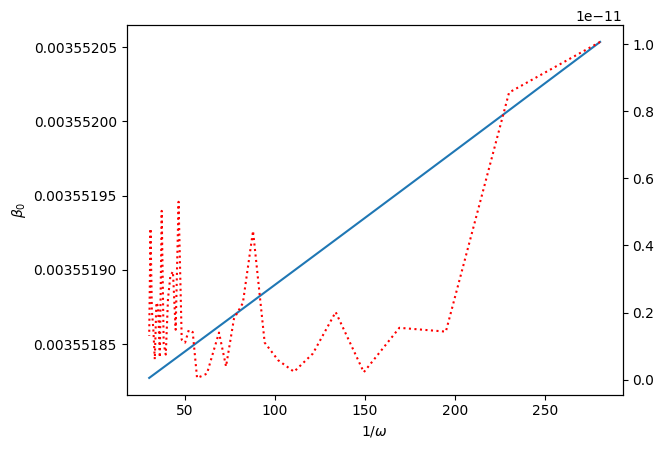

In [ ]:
pt.plot(1/omegas[1:], beta0[1:,0])
pt.xlabel(r'$1/\omega$')
pt.ylabel(r'$\beta_0$')
pt.twinx()
pt.plot(1/omegas[1:], np.abs(beta0[1:,1]), ":r")

In [ ]:
betas = np.linspace(0.00354, 0.00356, 40)
res2 = []
for beta in betas:
  res2.append(fit_function(beta, 1/30))
res2 = np.array(res2)

In [ ]:
pt.plot(betas, (res))
pt.plot(betas, (res2))
#pt.yscale('log')
#pt.xscale('log')
pt.grid()

NameError: name 'res' is not defined

In [ ]:
B0, omega = 0.12, 1/60
Hobs = 79
def fit_function(omega_aj, B0_aj):
    #(B0_aj, omega_aj) = variaveis                       # variáveis do sistema

    PSPUFIBGE2023      = np.array([10832832, 13556924, 12370914, 7650568])            #População Estado de SP
    PSPIBGE2023        = np.array([2674093, 3559246, 3195600, 2023060])               #População Cidade de SP
    vac_UFsp           = np.array([5121581, 13763379, 12133025, 7310940])             #Vacinados UF SP
    prop_vac = np.amin(np.c_[vac_UFsp/PSPUFIBGE2023, np.ones_like(vac_UFsp)], axis=1) #Proporção VACINADOS ESTADO DE SP
    prop_nvac = 1 - prop_vac                                                          #Proporção não VACINADOS ESTADO DE SP
    Nwsp_i = (prop_vac)  * PSPIBGE2023                                                #Estimativa VACINADOS Cidade DE São Paulo
    Nusp_i = (prop_nvac) * PSPIBGE2023                                                #Estimativa não VACINADOS Cidade DE São Paulo
    PropNusp_i = Nusp_i/PSPIBGE2023
    PropNwsp_i = Nwsp_i/PSPIBGE2023

    Matrix_Contact = np.array([[12.16225114,  3.5903678,   2.56136575,  0.57682922],
                                [ 3.26339927,  8.10131607,  4.24930738,  0.6747869 ],
                                [ 3.14804123,  4.9774246,   5.06808749,  0.79723409],
                                [ 2.36576344,  2.19144427,  2.07597498,  1.1998408 ]])
    mu_0, mu_1, mu_2, mu_3 =0.091, 0.144, 0.243, 0.473
    sigma_0, sigma_1, sigma_2, sigma_3 =0.001, 0.008, 0.021, 0.101
    alpha_0, alpha_1, alpha_2, alpha_3 =0.695, 0.440, 0.440, 0.310
    nu_0, nu_1, nu_2, nu_3 =1/9.59, 1/9.217,1/10.941, 1/12.534
    ro, tau, eta, gamma = 0.5, 0.5, 0.5, 1/5.8

    Sigma = np.array([sigma_0, sigma_1, sigma_2, sigma_3])
    Alpha = np.r_[alpha_0, alpha_1, alpha_2, alpha_3]
    Nu = np.array([nu_0, nu_1, nu_2, nu_3])

    E_Bn,  E_Bu,  E_Bv,  E_Bw  = 0, 0.599, 0.599, 0.599  # Efficacy (observed) against infectious contact 0, 0.499, 0.599, 0.699
    E_IHn, E_IHu, E_IHv, E_IHw = 0, 0.659, 0.659, 0.659  # Efficacy against clinical symptoms 0, 0.549, 0.659, 0.859
    E_Sn,  E_Su,  E_Sv,  E_Sw  = 0, 0.759, 0.759, 0.759  # Efficacy against hospitaization of infected individual 0, 0.599, 0.699, 0.89

    E_B  = np.array([E_Bn,E_Bu,E_Bv,E_Bw])
    E_IH = np.r_[E_IHn,E_IHu,E_IHv,E_IHw]
    E_S  = np.r_[E_Sn,E_Su,E_Sv,E_Sw]

    Epsilon_Bj = np.array([1-E_Bn,1-E_Bu,1-E_Bv,1-E_Bw])            #Epsilon_Bn,Epsilon_Bu,Epsilon_Bv,Epsilon_Bw
    Epsilon_Sj = np.array([(1-E_Sn)/(1-E_Bn), (1-E_Su)/(1-E_Bu),    #Epsilon_sigma
                            (1-E_Sv)/(1-E_Bv),(1-E_Sw)/(1-E_Bw)])    #Epsilon_Sn,Epsilon_Su,Epsilon_Sv,Epsilon_Sw
    Epsilon_Aj = (((1-E_IH)*(Sigma+(1-Sigma)*(1-Alpha))-(1-E_S)*Sigma)/
                  ((Epsilon_Bj)*(1-Epsilon_Sj*Sigma)*(1-Alpha)))

    #sigma_Epsilon, alpha_Epsilon = Epsilon_Sj*Sigma, Epsilon_Aj*Alpha
    sigma_Epsilon = np.outer(Sigma, Epsilon_Sj)
    alpha_Epsilon = np.outer(Alpha, Epsilon_Aj)

    DeltaA = (1-sigma_Epsilon) * alpha_Epsilon
    DeltaI = (1-sigma_Epsilon) * (1-alpha_Epsilon)
    DeltaH = sigma_Epsilon

    Tetha2u, Tetha2w = np.zeros(4), np.zeros(4)
    for i in range(4):
        Tetha2u[i] = ro/gamma + (DeltaA[i,1] +(1-tau)*DeltaI[i,1] +(1-eta)*DeltaH[i,1])/Nu[i]
        Tetha2w[i] = ro/gamma + (DeltaA[i,3] +(1-tau)*DeltaI[i,3] +(1-eta)*DeltaH[i,3])/Nu[i]

    def sist(Lambdai):
        return ( B0_aj * np.dot(Matrix_Contact,
          Lambdai*( (Epsilon_Bj*[1] * Tetha2u * PropNusp_i)/(1+Epsilon_Bj*[1]*Tetha2u*Lambdai)
          + (Epsilon_Bj*[3] * Tetha2w * PropNwsp_i)/(1+Epsilon_Bj*[3]*Tetha2w*Lambdai) )) - Lambdai )

    lamb = fsolve(sist, np.ones(4) * 1)
    Theta1 = 1/Nu + 1/omega_aj + 1/gamma

    Sucalc = Nusp_i /(1 + lamb * Epsilon_Bj[1] * Theta1)
    Swcalc = Nwsp_i /(1 + lamb * Epsilon_Bj[3] * Theta1)

    Hucalc = Sucalc * lamb * Epsilon_Bj[1] * DeltaH[:,1] / Nu
    Hwcalc = Swcalc * lamb * Epsilon_Bj[3] * DeltaH[:,3] / Nu

    Htot = Hucalc.sum() + Hwcalc.sum()

    return Htot - Hobs

In [ ]:
s0 = (1/60,)
s = least_squares(fit_function, s0, gtol=None, max_nfev=1000, bounds = [1/400, 1/20], args=(1.44334e-2,))
print(s)
print(1/s.x[0])

In [ ]:
res = np.c_[omegas, beta0]
pt.plot(1/res[1:,0], res[1:,2])

#Próximos passos

para ajustar para outras cidades, os parâmetros que mudam:
* vetor de população Estado
* vetor de população cidade
* proporção de vacinados por faixa etária
* número de hospitalizações observados
* recalcular matriz de contato

## teste
* simular o modelo
* comparar com modelo simples (ver foto)
